In [8]:
"""
27/12/2020 - last version

Doron Zusman
Ben Hen
Omer Yarchi
"""

import heapq
import numpy as np
import matplotlib.pyplot as plt
import random

run_times_for_policy = 1 #number of runs we want for the simulation - (N1 = 5 for epsilon 14.8, N2 = 11 for epsilon is 0.6)
policy = 2 #The policy we decide for the simulation 
number_of_sim_days = 10 # How many days the simulation will run

n0 = run_times_for_policy
seeds=[42+i for i in range(n0)]

In [9]:
class Customer:
    def __init__(self,arrival,curr_floor,dest,need_for_elevator):
        self.arrival = arrival #arrival time
        self.dest = dest #destination level
        self.got_service = False #did the customer get service
        self.need_for_elevator = need_for_elevator #[] - doesn't need to change elevator, else he'll will have a list of elevators for his destination
        self.curr_floor = curr_floor #current level

In [10]:
class Elevator:
    def __init__(self,elevatorType,state):
        if policy == 2: # in policy 2 elevator doesn't have specific floors range= can go from 0 to 25 without any limitation
            self.elevatorID = elevatorType
            self.elevatorType = elevatorType
            self.max_floor = 25
            self.almost_min_floor = 1
        else: #policies 0 or 1
            self.elevatorID = elevatorType #1-15,0 levels - E1,E2 ; 16-25,0 levels - E3,E4
            self.elevatorType = elevatorType
            if self.elevatorID == 1 or self.elevatorID==2:
                self.max_floor = 15
                self.almost_min_floor = 1
            else:
                if policy==3:
                    self.elevatorType = 2
                    self.max_floor = 15
                    self.almost_min_floor = 1
                else:    
                    self.max_floor = 25
                    self.almost_min_floor = 16
        self.capacity = 0 #the capacity of the elevator
        self.customers = [] #list of C (customers) in the elevator
        self.curr_floor = 0 #current level, starts at ground floor 
        self.up = True #if it goes up - True, down - False
        self.state = state #The state of the elevator:(0=closed/1=open doors/2=broken elevator)
                
def part_of_day(curr_time): #we work in hours, what is the part of the day based on the current time, 14 hours 6:00 to 20:00
    if curr_time%14>=1 and curr_time%14<4:
        return 1 #7:00 to 10:00
    elif curr_time%14>=9 and curr_time%14<12:
        return 2 #15:00 to 18:00
    else:
        return 0 # rest of the work day

In [11]:
class Event:
    def __init__(self, eventType, time, elevator=None):
        self.time = time #execution time of the event
        self.eventType = eventType #type of the event
        self.elevator = elevator #elevator that is part of this event
        heapq.heappush(P, self) #event is pushed to event list P when created
        
    def __lt__(self,event2):
        return self.time < event2.time

In [12]:
rate = [[],[],[]] #each sub list describes the lambdas of the poisson rate of arrival to the buliding
probabilities = [[],[],[]] #each sub list describes the probabilities for each sub list from ktavim

floors_pairs=[(i,j+1) for i in range(26) for j in range(-1,25) if i!=j+1] # A list for every possible match of floors
data_set=[[4,7,4,0.4,0.4,7,0.4,0.4],[6,12,10,0.4,0.4,40,0.4,0.4],[10,40,6,0.4,0.4,12,0.4,0.4]]              

for data in data_set:
    for pair in floors_pairs:
        if pair[0]==0:                                        #from ground floor
            if pair[1]<16:                                      # to floor between 1-15
                rate[data_set.index(data)].append(data[0])
            else:                                               # to floor between 16-25
                rate[data_set.index(data)].append(data[1])
        elif pair[0]>0 and pair[0]<16:                        # from floor between 1- 15
            if pair[1]==0:                                       # to ground floor
                rate[data_set.index(data)].append(data[2])
            elif pair[1]>0 and pair[1]<16:                       # to floor between 1-15
                rate[data_set.index(data)].append(data[3])
            else:                                                # to floor between  16-25
                rate[data_set.index(data)].append(data[4])
        elif pair[0]>15:                                      # from floor between 16-25
            if pair[1]==0:                                      # to ground floor
                rate[data_set.index(data)].append(data[5])
            elif pair[1]>0 and pair[1]<16:                      # to floor between  1-15
                rate[data_set.index(data)].append(data[6])
            else:                                               # to floor between  16-25
                rate[data_set.index(data)].append(data[7])
                
for j in range(len(probabilities)):  # creating probabilities for each pair of floors in floors_pairs            
    for i in range(len(floors_pairs)):
        probabilities[j].append(rate[j][i]/sum(rate[j]))


In [13]:
lst_policy_abn = []
for run in range(run_times_for_policy):
    print("start of run "+str(run+1)+" of policy "+str(policy))
    #Initializing
    np.random.seed(seeds[run])
    DLeavers =0
    Leavers = 0 #customers that left the system 
    Service_time = {} #counts the customers for each range of service duration

    for i in range(8):
        Service_time[str(5*i/60)] = 0
    Service_time["40/60 +"] = 0

    S1 = {k:0 for k in range (0,16)} #human_time in elevator 1, capacity in range 0 to 15 people in the elevator 
    S2 = {k:0 for k in range (0,16)} #human_time in elevator 2, capacity in range 0 to 15 people in the elevator 
    S3 = {k:0 for k in range (0,16)} #human_time in elevator 3, capacity in range 0 to 15 people in the elevator 
    S4 = {k:0 for k in range (0,16)} #human_time in elevator 4, capacity in range 0 to 15 people in the elevator 

    Data=[1/500,1/1000,1/1000]
    #Start of the simulation    
    for i in range(number_of_sim_days):
       # DLeavers = 0
        print ("start of day "+str(i+1))
        #initialize the event's list 
        P = []
        E1 = Elevator(1,0)
        E2 = Elevator(2,0) 
        E3 = Elevator(3,0) 
        E4 = Elevator(4,0) 

        #creating the first customer arrival
        x = np.random.exponential(1/500)
        Event("Arrival",x)    

        T_now = 0 #current event time
        T_prev = 0 #previous event time
        T_max = 14 #workday length
        B = part_of_day(T_now) #simulation starts at 6AM so it will be 0

        ##creating the first opened elevator events ##
        Event("Open Doors",T_now,E1)
        Event("Open Doors",T_now,E2)
        Event("Open Doors",T_now,E3)
        Event("Open Doors",T_now,E4)

        customers_in_floors = {i:[] for i in range(0,26)} #live of customers waiting in each floor

        while T_now < T_max: 
            B = part_of_day(T_now)
            event = heapq.heappop(P)
            T_prev = T_now
            T_now = event.time
            delta=T_now-T_prev


        # Update human-time for every elevator
            S1[E1.capacity] +=delta 
            S2[E2.capacity] +=delta
            S3[E3.capacity] +=delta
            S4[E4.capacity] +=delta

        #first type of event -  customer arrival to the system
            if event.eventType == "Arrival":
                #based on the part of the day, we deside the arrival's probability
                pair = np.random.choice(range(len(floors_pairs)),p = probabilities[B]) 
                x = np.random.exponential(Data[B]) #creating the time for the next customer
                if policy==2:
                    floors = floors_pairs[pair]
                    need_for_elevator=[]
                else:
                    floors = floors_pairs[pair]
                    need_for_elevator = []
                    if policy != 3:
                        if floors[0] == 0: #if at ground floor, which elevator the customer needs
                            if floors[1] < 16: 
                                need_for_elevator = [1,2]
                            else:
                                need_for_elevator = [3,4]
                        elif floors[0] < 16: 
                            if floors[1] > 16: #switch is needed
                                need_for_elevator = [3,4]
                        elif floors[0] > 15: 
                            if floors[1] < 16 and floors[1] != 0: #the switch is needed
                                need_for_elevator = [1,2]
                    else:
                        if floors[0] == 0:
                            if floors[1] < 16: 
                                need_for_elevator = [1,2,3]
                            else:
                                need_for_elevator = [4]
                        elif floors[0] < 16: 
                            if floors[1] > 16: #switch is needed
                                need_for_elevator = [4]
                        elif floors[0] > 15: 
                            if floors[1] < 16 and floors[1] != 0: #the switch is needed
                                need_for_elevator = [1,2,3]                        

                new_customer = Customer(T_now,floors[0],floors[1],need_for_elevator)
                customers_in_floors[floors[0]].append(new_customer) #add the customer to the line in this floor
                Event("Arrival",T_now + x) #creating the next arriving

        #second type of event - "Open Doors"
            elif event.eventType == "Open Doors":
                elevator = event.elevator #the elevator of the current event
                elevator.state = 1 #change the elevaotor's state to 1 = open doors

                x = np.random.random(1) #check if the elevator is broken or not
                if x <= 0.0005: #if broken
                    elevator.state = 2 #the elevator is broken
                    curr_capacity = len(elevator.customers) 
                    temp_leavers = [] #list that will helps us to remove the leavers from the elevator
                    if elevator.capacity > 0: #if there are customers inside the elevator
                        for i in range(curr_capacity): 
                            temp_leavers.append(elevator.customers[i]) #add the leaving customers in order to remove them later from the elevator
                            customers_in_floors[elevator.curr_floor].append(elevator.customers[i]) #add the customers to the queue in this level
                            elevator.capacity -= 1 #change the number of customers in the elevator 

                        #removing the customers from the broken elevator
                        for l in temp_leavers:
                            elevator.customers.remove(l)
                    #create the broken elevator's fix time
                    Event("Broken elevator is fixed",T_now+np.random.uniform(5/60,15/60),elevator)

                else: #the elevator is not broken
                    if elevator.capacity != 0: #check if elevator isn't empty
                        temp_leavers = [] #list that will helps us to remove the leavers from the elevator
                        curr_capacity = len(elevator.customers) 

                        for i in range(curr_capacity):
                            if elevator.customers[i].dest == elevator.curr_floor: #if the customer reached his destination floor     
                                elevator.capacity -= 1 #update elevator's capacity
                                temp_leavers.append(elevator.customers[i]) #add the leavers to temp list

                                service_t = T_now-elevator.customers[i].arrival #service time of the customer
                                for i in range(8): #which range of service time we need to update
                                    if service_t >= i/12 and service_t <= (i+1)/12: 
                                        Service_time[str(i/12)] += 1
                                if service_t > 40/60: #more than 40 minutes
                                    Service_time["40/60 +"] += 1 

                            elif elevator.curr_floor == 0 and policy!=2: #check if the elevator is in ground level
                                if elevator.customers[i].need_for_elevator != []: #if the customer has to change the elevator to get to his destination
                                    elevator.capacity -= 1 #update elevator's capacity
                                    temp_leavers.append(elevator.customers[i]) 
                                    customers_in_floors[0].append(elevator.customers[i]) #add customer to the line at ground floor 

                        #removing the customers who existed the elevator            
                        if temp_leavers != []:
                            for l in temp_leavers:
                                elevator.customers.remove(l)
                        temp_leavers.clear()       
                    Event("Closed Doors",T_now + 5/3600,elevator) #creating the closed door event, 5 seconds

        #third type of event - Closed Doors
            elif event.eventType == "Closed Doors": 
                elevator = event.elevator  #the elevator type which belongs to current event
                elevator.state = 0 #the elevator doors are now closed

                line=len(customers_in_floors[elevator.curr_floor])
                abn_lst = [] 

                for i in range(line): #check in the line in current floor
                    if (T_now-customers_in_floors[elevator.curr_floor][i].arrival >= 15/60) and (customers_in_floors[elevator.curr_floor][i].got_service == False):

                        abn_lst.append(customers_in_floors[elevator.curr_floor][i])
                        Leavers += 1 #we update the number of abandoners
                        DLeavers += 1

                #remove the abandoners from queue if there are any
                if abn_lst != []:
                    for a in abn_lst:
                        customers_in_floors[elevator.curr_floor].remove(a)
                abn_lst.clear()

                travellers = [] #list of customers who enter the elevator from the line

                if elevator.capacity < 15: #if there is available place in the elevator
                    if elevator.curr_floor == 0: #check if the floor is ground floor
                        line=len(customers_in_floors[elevator.curr_floor])

                        if customers_in_floors[elevator.curr_floor] != []: #there are customers waiting in current floor

                            for i in range(line):
                               #if the elevator is relevant for the customer
                                if policy !=2:
                                    if elevator.elevatorID in customers_in_floors[elevator.curr_floor][i].need_for_elevator and elevator.capacity < 15:
                                        customers_in_floors[elevator.curr_floor][i].gor_service=True #the customer can't abandon
                                        elevator.customers.append(customers_in_floors[elevator.curr_floor][i])#add the customer to the elevator
                                        elevator.capacity += 1 
                                        travellers.append(customers_in_floors[elevator.curr_floor][i])#add the customer to the list so we can remove him/her from the line 
                                else:
                                    if elevator.capacity < 15:
                                        customers_in_floors[elevator.curr_floor][i].gor_service=True #the customer can't abandon
                                        elevator.customers.append(customers_in_floors[elevator.curr_floor][i])#add the customer to the elevator
                                        elevator.capacity += 1 
                                        travellers.append(customers_in_floors[elevator.curr_floor][i])#add the customer to the list so we can remove him/her from the line 

                            #remove the customers from the current floor line
                            if travellers != []: 
                                for t in travellers:
                                    customers_in_floors[elevator.curr_floor].remove(t)

                    else: #if the floor is not ground floor
                        line=len(customers_in_floors[elevator.curr_floor])

                        if customers_in_floors[elevator.curr_floor] != []: #if there is a queue in the current level
                            for i in range(line):
                                #if there is enough place in the elevator
                                if elevator.capacity < 15:
                                    customers_in_floors[elevator.curr_floor][i].gor_service=True #the customer can't abandon
                                    elevator.customers.append(customers_in_floors[elevator.curr_floor][i])#add the customer to the elevator
                                    elevator.capacity += 1 
                                    travellers.append(customers_in_floors[elevator.curr_floor][i])#add the customer to the list so we can remove him/her from the line 

                            #remove the customers from the current floor line
                            if travellers != []:
                                for t in travellers:
                                    customers_in_floors[elevator.curr_floor].remove(t)
                travellers.clear()

                move=1
                if elevator.curr_floor == 0:

                    if policy!=2 and (elevator.elevatorType == 3 or elevator.elevatorType == 4):
                        move=16
                    elevator.up=True
                    if policy==1 or policy==2:
                        min_move=elevator.max_floor+1
                        if elevator.capacity>0:
                            for customer in elevator.customers:
                                if customer.dest<min_move:
                                    min_move=customer.dest
                            move=min_move
                    elevator.curr_floor+=move
                else:
                    if elevator.up==True:
                        if elevator.curr_floor<elevator.max_floor:
                            if policy==1 or policy==2:
                                if elevator.capacity>0:
                                    min_move=elevator.max_floor+1
                                    for customer in elevator.customers:
                                        x = elevator.curr_floor-customer.dest
                                        y = customer.dest-elevator.curr_floor
                                        if policy!=2:
                                            if x<0 and elevator.elevatorID in customer.need_for_elevator:
                                                if y<min_move:
                                                    min_move = y
                                        else:
                                            if x<0:
                                                if y<min_move:
                                                    min_move = y
                                    if min_move!=(elevator.max_floor+1):
                                        move=min_move
                            elevator.curr_floor+=move
                        else:
                            elevator.up=False
                            if policy==1 or policy==2:
                                if elevator.capacity>0:
                                    min_move=elevator.max_floor+1
                                    x = elevator.curr_floor-customer.dest
                                    for customer in elevator.customers:
                                        if policy!=2:
                                            if x > 0 and elevator.elevatorType in customer.need_for_elevator:
                                                if x < min_move:
                                                    min_move = x
                                        else:
                                            if x > 0:
                                                if x < min_move:
                                                    min_move = x
                                    if min_move!=(elevator.max_floor+1):
                                        move=min_move         
                            elevator.curr_floor-=move
                    else:
                        if elevator.curr_floor==elevator.almost_min_floor:
                            if policy!=2 and (elevator.elevatorType == 3 or elevator.elevatorType == 4):
                                move=16
                            elevator.curr_floor-=move
                        else:
                            if policy==1 or policy==2:
                                if elevator.capacity>0:
                                    min_move=elevator.max_floor+1
                                    for customer in elevator.customers:
                                        x = elevator.curr_floor-customer.dest
                                        if policy!=2:
                                            if x > 0 and elevator.elevatorID in customer.need_for_elevator:
                                                    if x<min_move:
                                                        min_move = x
                                        else:
                                            if x > 0:
                                                    if x<min_move:
                                                        min_move = x
                                    if min_move!=elevator.max_floor+1:
                                        move=min_move
                            elevator.curr_floor-=move
                #we check what is the correct time to create "opened elevator" event depends on what level and which elevator is serving now
                T_move =  (move + 4)/3600               
                Event("Open Doors",T_now+T_move,elevator) #create opened elevator

     #forth type of event -Broken elevator is fixed
            elif event.eventType == "Broken elevator is fixed":
                elevator = event.elevator
                elevator.state = 0
                Event("Closed Doors",T_now + 5/3600,elevator)
                
       
      #  print ("today the leavers were "+str(DLeavers))
        
        #Average abandoners of 
    print("for policy "+str(policy)+ " at run number "+str(int(run+1)))
    print("The average number of abandoners is " + str(Leavers/number_of_sim_days))
    lst_policy_abn.append(Leavers/number_of_sim_days)

    
print ("the list is: ")
print (lst_policy_abn)

start of run 1 of policy 2
start of day 1
start of day 2
start of day 3
start of day 4
start of day 5
start of day 6
start of day 7
start of day 8
start of day 9
start of day 10
for policy 2 at run number 1
The average number of abandoners is 6.3
the list is: 
[6.3]


for policy 2
Average number of abandoners is 6.3


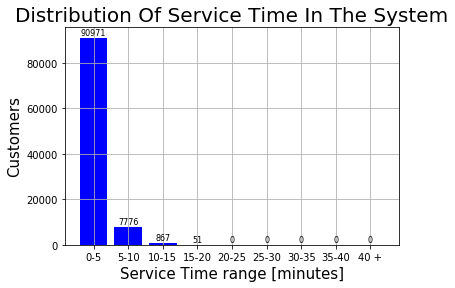

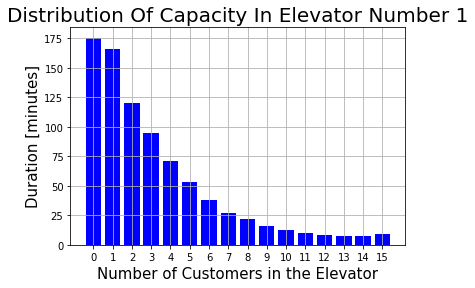

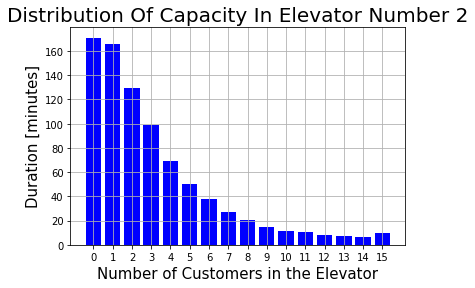

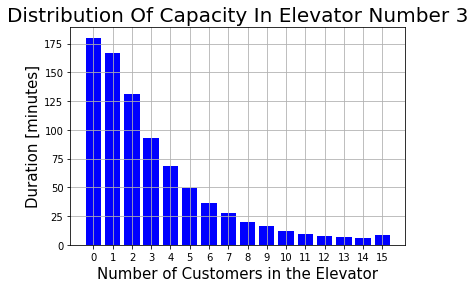

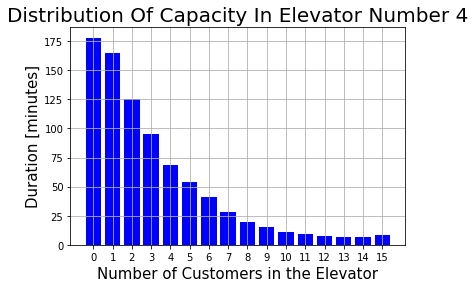

In [14]:
#Output

#Average abandoners
print("for policy "+str(policy))
print("Average number of abandoners is " + str(Leavers/number_of_sim_days))

###########service duration plot########
customers_num_per_range = []
for i in Service_time:
    customers_num_per_range.append(Service_time[i])
ranges = [str(i*5) + "-" + str(i*5 + 5) for i in range(8)]
ranges.append("40 +")
plt.bar(ranges, customers_num_per_range,color="blue")
plt.xticks(ranges)
plt.grid()
plt.title('Distribution Of Service Time In The System', size=20)
plt.ylabel("Customers",size=15)
plt.xlabel("Service Time range [minutes]",size=15)
for x,y in zip(ranges,customers_num_per_range):
    label = "{:}".format(y)
    plt.annotate(label, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                 xytext=(0,3), # distance from text to points (x,y)
                 size=8,ha='center')
plt.show()

## first elevator's occupation (1-15 levels) plot##

all_s=[S1,S2,S3,S4]
for S in all_s:
    duration = []
    for i in S:
        duration.append(S[i]*60/number_of_sim_days)
    occupation = [i for i in range(16)]
    plt.bar(occupation, duration,color="blue")
    plt.xticks(occupation)
    plt.grid()
    plt.title('Distribution Of Capacity In Elevator Number '+str(all_s.index(S)+1), size=20)
    plt.ylabel("Duration [minutes]",size=15)
    plt.xlabel("Number of Customers in the Elevator",size=15)
    plt.show()